**Updated**: 29.07.2021

In [1]:
import numpy as np
import sqlite3 as sq
import matplotlib.pyplot as plt
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

from colors import Colors

%matplotlib inline

In [2]:
connection = sq.connect("./measurements.db")
connection.row_factory = sq.Row

In [43]:
def average(items, key):
    total = 0
    for item in items:
        try:
            total += item[key]
        except:
            pass
    return total/len(items)

def getTraceroutesForProtocol(protocol):
    def generateStatement(protocol):
        return "SELECT ip FROM dns_measurements {} WHERE {}.protocol = '{}' AND {}.response_ip IS NOT NULL AND NOT {}.cache_warming".format(protocol, protocol, protocol, protocol, protocol)
    statements = {
        "udp": generateStatement("udp"),
        "tcp": generateStatement("tcp"),
        "tls": generateStatement("tls"),
        "https": generateStatement("https"),
        "quic": generateStatement("quic")
    }
    del statements[protocol]
    sql = """
    SELECT * from traceroutes WHERE (dns_measurement_id, hop_ip, dest_port, protocol) IN (SELECT id, ip, port, protocol FROM dns_measurements measurement
    WHERE measurement.protocol = '{}' AND measurement.r_code IS NOT NULL AND measurement.total_time IS NOT NULL AND measurement.total_time <= 5000000000
      AND NOT measurement.cache_warming
      AND measurement.ip IN ({})
      AND measurement.ip IN ({})
      AND measurement.ip IN ({})
      AND measurement.ip IN ({}));
    """.format(protocol, *statements.values())
    df = pd.read_sql_query(sql, connection)
    return df

def getTraceroutesForProtocolPairwise(protocol):
    def generateStatement(protocol):
        return "SELECT ip FROM dns_measurements {} WHERE {}.protocol = '{}' AND {}.response_ip IS NOT NULL AND NOT {}.cache_warming".format(protocol, protocol, protocol, protocol, protocol)
    statements = {
        "udp": generateStatement("udp"),
        "tcp": generateStatement("tcp"),
        "tls": generateStatement("tls"),
        "https": generateStatement("https"),
        "quic": generateStatement("quic")
    }
    del statements[protocol]
    sql = """
    SELECT * from traceroutes WHERE (dns_measurement_id, hop_ip, dest_port, protocol) IN (SELECT id, ip, port, protocol FROM dns_measurements measurement
    WHERE measurement.protocol = '{}' AND measurement.r_code IS NOT NULL AND measurement.total_time IS NOT NULL AND measurement.total_time <= 5000000000
      AND NOT measurement.cache_warming
      AND measurement.ip IN ({})
      AND measurement.ip IN ({})
      AND measurement.ip IN ({})
      AND measurement.ip IN ({})) 
      AND hop_ip IN (SELECT DISTINCT(hop_ip) FROM traceroutes WHERE protocol = 'udp' AND hop_ip = dest_ip)
      AND hop_ip IN (SELECT DISTINCT(hop_ip) FROM traceroutes WHERE protocol = 'quic' AND hop_ip = dest_ip)
      AND hop_ip IN (SELECT DISTINCT(hop_ip) FROM traceroutes WHERE protocol = 'tcp' AND hop_ip = dest_ip)
      AND hop_ip IN (SELECT DISTINCT(hop_ip) FROM traceroutes WHERE protocol = 'tls' AND hop_ip = dest_ip)
      AND hop_ip IN (SELECT DISTINCT(hop_ip) FROM traceroutes WHERE protocol = 'https' AND hop_ip = dest_ip);
    """.format(protocol, *statements.values())
    df = pd.read_sql_query(sql, connection)
    return df

def getMeanTraceroutesPairwise():
    udp = getTraceroutesForProtocolPairwise("udp")["rtt"].div(1000000)
    tcp = getTraceroutesForProtocolPairwise("tcp")["rtt"].div(1000000)
    tls = getTraceroutesForProtocolPairwise("tls")["rtt"].div(1000000)
    https = getTraceroutesForProtocolPairwise("https")["rtt"].div(1000000)
    quic = getTraceroutesForProtocolPairwise("quic")["rtt"].div(1000000)
    
    fig = plt.figure(figsize = (10, 7))
    ax = fig.add_subplot(111)
    bp = ax.boxplot([udp.values.tolist(), tcp.values.tolist(), tls.values.tolist(), https.values.tolist(), quic.values.tolist()], vert = 0, showfliers = False)

    ax.set_yticklabels(["UDP", "TCP", "TLS", "HTTPS", "QUIC"])

    ax.set_xlabel("ms", fontsize = 12)
    ax.set_ylabel("Protocol", fontsize = 12)
    plt.title("RTT for Hosts with all Protocols Reachable")

    plt.show(bp)
    
    df = pd.DataFrame({ 
        "Protocol": ["UDP", "TCP", "TLS", "HTTPS", "QUIC"],
        "Samples": [len(udp), len(tcp), len(tls), len(https), len(quic)]
    })
    print(df.to_markdown())
    
def getMeanTraceroutes():
    udp_df = getTraceroutesForProtocolPairwise("udp")
    udp_df["rtt"] = udp_df["rtt"].div(1000000)
    tcp_df = getTraceroutesForProtocolPairwise("tcp")
    tcp_df["rtt"] = tcp_df["rtt"].div(1000000)
    tls_df = getTraceroutesForProtocolPairwise("tls")
    tls_df["rtt"] = tls_df["rtt"].div(1000000)
    https_df = getTraceroutesForProtocolPairwise("https")
    https_df["rtt"] = https_df["rtt"].div(1000000)
    quic_df = getTraceroutesForProtocolPairwise("quic")
    quic_df["rtt"] = quic_df["rtt"].div(1000000)
    
    udp = udp_df.groupby("dest_ip")["rtt"].median().reset_index()["rtt"]
    tcp = tcp_df.groupby("dest_ip")["rtt"].median().reset_index()["rtt"]
    tls = tls_df.groupby("dest_ip")["rtt"].median().reset_index()["rtt"]
    https = https_df.groupby("dest_ip")["rtt"].median().reset_index()["rtt"]
    quic = quic_df.groupby("dest_ip")["rtt"].median().reset_index()["rtt"]
    
    fig = plt.figure(figsize = (10, 7))
    ax = fig.add_subplot(111)
    bp = ax.boxplot([udp.values.tolist(), tcp.values.tolist(), tls.values.tolist(), https.values.tolist(), quic.values.tolist()], vert = 0, showfliers = False)

    ax.set_yticklabels(["UDP", "TCP", "TLS", "HTTPS", "QUIC"])

    ax.set_xlabel("ms", fontsize = 12)
    ax.set_ylabel("Protocol", fontsize = 12)
    plt.title("RTT")

    plt.show(bp)
    
def getQUICMedianTraceroutes(cacheWarming = False, protocol = "quic"):
    cacheCondition = "AND NOT d.cache_warming" if not cacheWarming else "AND d.cache_warming"
    sql = """
    SELECT
       d.id, d.ip, d.port, d.protocol, d.q_ui_c_handshake_duration as quic_handshake_duration, query_time, tcp_handshake_duration, tls_handshake_duration
    FROM dns_measurements d
    WHERE d.protocol = '{}' {}
    AND d.id IN (SELECT DISTINCT(t.dns_measurement_id) FROM traceroutes t where t.dest_ip = t.hop_ip AND t.protocol = '{}');
    """.format(protocol, cacheCondition, protocol)
    handshake_duration = pd.read_sql_query(sql, connection)
    sql = """
    SELECT
    t.dns_measurement_id as id, dest_port as port, protocol, dest_ip, hop_ip, rtt
    FROM traceroutes t
    WHERE t.protocol = '{}' AND t.dest_ip = t.hop_ip
    """.format(protocol)
    rtts = pd.read_sql_query(sql, connection).groupby("id").sample(n = 1)
    return pd.merge(handshake_duration, rtts, on = "id")

def getQUICMedianResolveTime():
    sql = """
    SELECT ip, query_time FROM dns_measurements measurement
    WHERE measurement.protocol = 'quic' AND measurement.r_code IS NOT NULL AND measurement.total_time IS NOT NULL AND measurement.total_time <= 5000000000
      AND NOT measurement.cache_warming
      AND measurement.ip IN (SELECT ip FROM dns_measurements udp WHERE udp.protocol = 'udp' AND udp.response_ip IS NOT NULL AND NOT udp.cache_warming)
      AND measurement.ip IN (SELECT ip FROM dns_measurements tcp WHERE tcp.protocol = 'tcp' AND tcp.response_ip IS NOT NULL AND NOT tcp.cache_warming)
      AND measurement.ip IN (SELECT ip FROM dns_measurements tls WHERE tls.protocol = 'tls' AND tls.response_ip IS NOT NULL AND NOT tls.cache_warming)
      AND measurement.ip IN (SELECT ip FROM dns_measurements https WHERE https.protocol = 'https' AND https.response_ip IS NOT NULL AND NOT https.cache_warming);
    """
    quic_df = pd.read_sql_query(sql, connection)
    quic_df["query_time"] = quic_df["query_time"].div(1000000)
    
    quic = quic_df.groupby("ip")["query_time"].median().reset_index()
    return quic

def getUDP():
    sql = """
    SELECT * FROM dns_measurements measurement
    WHERE measurement.protocol = 'udp' AND measurement.r_code IS NOT NULL AND measurement.total_time IS NOT NULL AND measurement.total_time <= 5000000000
      AND NOT measurement.cache_warming
      AND measurement.ip IN (SELECT ip FROM dns_measurements tcp WHERE tcp.protocol = 'tcp' AND tcp.response_ip IS NOT NULL AND NOT tcp.cache_warming)
      AND measurement.ip IN (SELECT ip FROM dns_measurements tls WHERE tls.protocol = 'tls' AND tls.response_ip IS NOT NULL AND NOT tls.cache_warming)
      AND measurement.ip IN (SELECT ip FROM dns_measurements https WHERE https.protocol = 'https' AND https.response_ip IS NOT NULL AND NOT https.cache_warming)
      AND measurement.ip IN (SELECT ip FROM dns_measurements quic WHERE quic.protocol = 'quic' AND quic.response_ip IS NOT NULL AND NOT quic.cache_warming);
    """
    cursor = connection.cursor()
    cursor.execute(sql)
    items = list(cursor.fetchall())
    cursor.close()
    return items

def getTCP():
    sql = """
    SELECT * FROM dns_measurements measurement
    WHERE measurement.protocol = 'tcp' AND measurement.r_code IS NOT NULL AND measurement.total_time IS NOT NULL AND measurement.total_time <= 5000000000
      AND NOT measurement.cache_warming
      AND measurement.ip IN (SELECT ip FROM dns_measurements udp WHERE udp.protocol = 'udp' AND udp.response_ip IS NOT NULL AND NOT udp.cache_warming)
      AND measurement.ip IN (SELECT ip FROM dns_measurements tls WHERE tls.protocol = 'tls' AND tls.response_ip IS NOT NULL AND NOT tls.cache_warming)
      AND measurement.ip IN (SELECT ip FROM dns_measurements https WHERE https.protocol = 'https' AND https.response_ip IS NOT NULL AND NOT https.cache_warming)
      AND measurement.ip IN (SELECT ip FROM dns_measurements quic WHERE quic.protocol = 'quic' AND quic.response_ip IS NOT NULL AND NOT quic.cache_warming);
    """
    cursor = connection.cursor()
    cursor.execute(sql)
    items = list(cursor.fetchall())
    cursor.close()
    return items

def getTLS():
    sql = """
    SELECT * FROM dns_measurements measurement
    WHERE measurement.protocol = 'tls' AND measurement.r_code IS NOT NULL AND measurement.total_time IS NOT NULL AND measurement.total_time <= 5000000000
      AND NOT measurement.cache_warming
      AND measurement.ip IN (SELECT ip FROM dns_measurements udp WHERE udp.protocol = 'udp' AND udp.response_ip IS NOT NULL AND NOT udp.cache_warming)
      AND measurement.ip IN (SELECT ip FROM dns_measurements tcp WHERE tcp.protocol = 'tcp' AND tcp.response_ip IS NOT NULL AND NOT tcp.cache_warming)
      AND measurement.ip IN (SELECT ip FROM dns_measurements https WHERE https.protocol = 'https' AND https.response_ip IS NOT NULL AND NOT https.cache_warming)
      AND measurement.ip IN (SELECT ip FROM dns_measurements quic WHERE quic.protocol = 'quic' AND quic.response_ip IS NOT NULL AND NOT quic.cache_warming);
    """
    cursor = connection.cursor()
    cursor.execute(sql)
    items = list(cursor.fetchall())
    cursor.close()
    return items

def getHTTPS():
    sql = """
    SELECT * FROM dns_measurements measurement
    WHERE measurement.protocol = 'https' AND measurement.r_code IS NOT NULL AND measurement.total_time IS NOT NULL AND measurement.total_time <= 5000000000
      AND NOT measurement.cache_warming
      AND measurement.ip IN (SELECT ip FROM dns_measurements udp WHERE udp.protocol = 'udp' AND udp.response_ip IS NOT NULL AND NOT udp.cache_warming)
      AND measurement.ip IN (SELECT ip FROM dns_measurements tcp WHERE tcp.protocol = 'tcp' AND tcp.response_ip IS NOT NULL AND NOT tcp.cache_warming)
      AND measurement.ip IN (SELECT ip FROM dns_measurements tls WHERE tls.protocol = 'tls' AND tls.response_ip IS NOT NULL AND NOT tls.cache_warming)
      AND measurement.ip IN (SELECT ip FROM dns_measurements quic WHERE quic.protocol = 'quic' AND quic.response_ip IS NOT NULL AND NOT quic.cache_warming);
    """
    cursor = connection.cursor()
    cursor.execute(sql)
    items = list(cursor.fetchall())
    cursor.close()
    return items

def getQUIC():
    sql = """
    SELECT * FROM dns_measurements measurement
    WHERE measurement.protocol = 'quic' AND measurement.r_code IS NOT NULL AND measurement.total_time IS NOT NULL AND measurement.total_time <= 5000000000
      AND NOT measurement.cache_warming
      AND measurement.ip IN (SELECT ip FROM dns_measurements udp WHERE udp.protocol = 'udp' AND udp.response_ip IS NOT NULL AND NOT udp.cache_warming)
      AND measurement.ip IN (SELECT ip FROM dns_measurements tcp WHERE tcp.protocol = 'tcp' AND tcp.response_ip IS NOT NULL AND NOT tcp.cache_warming)
      AND measurement.ip IN (SELECT ip FROM dns_measurements tls WHERE tls.protocol = 'tls' AND tls.response_ip IS NOT NULL AND NOT tls.cache_warming)
      AND measurement.ip IN (SELECT ip FROM dns_measurements https WHERE https.protocol = 'https' AND https.response_ip IS NOT NULL AND NOT https.cache_warming);
    """
    cursor = connection.cursor()
    cursor.execute(sql)
    items = list(cursor.fetchall())
    cursor.close()
    return items

def getQUICNegotiatedProtocol():
    sql = """
    SELECT DISTINCT(measurement.ip), measurement.q_ui_c_negotiated_protocol FROM dns_measurements measurement
    WHERE measurement.protocol = 'quic' AND measurement.r_code IS NOT NULL
    AND NOT measurement.cache_warming;
    """
    cursor = connection.cursor()
    cursor.execute(sql)
    items = list(cursor.fetchall())
    cursor.close()
    return items

def getQUICVersions():
    sql = """
    SELECT DISTINCT(measurement.ip), measurement.q_ui_c_version FROM dns_measurements measurement
    WHERE measurement.protocol = 'quic' AND measurement.r_code IS NOT NULL
    AND NOT measurement.cache_warming;
    """
    cursor = connection.cursor()
    cursor.execute(sql)
    items = list(cursor.fetchall())
    cursor.close()
    return items

def getNumberOfSamples():
    udp = len(getUDP())
    tcp = len(getTCP())
    tls = len(getTLS())
    https = len(getHTTPS())
    quic = len(getQUIC())
    return pd.DataFrame({ 
        "Protocol": ["UDP", "TCP", "TLS", "HTTPS", "QUIC"],
        "Samples": [udp, tcp, tls, https, quic]
    })

def getData():
    udp = getUDP()
    tcp = getTCP()
    tls = getTLS()
    https = getHTTPS()
    quic = getQUIC()
    return pd.DataFrame(udp + tcp + tls + https + quic, columns = udp[0].keys())

### Total Servers used

In [4]:
allData = getData()
len(allData["ip"].unique())

188

### Average Total Times

In [5]:
print(average(getUDP(), "total_time") / 1000000)
print(average(getTCP(), "total_time") / 1000000)
print(average(getTLS(), "total_time") / 1000000)
print(average(getHTTPS(), "total_time") / 1000000)
print(average(getQUIC(), "total_time") / 1000000)

133.4439886622728
267.1019443489733
411.24129024031475
405.6914702318508
454.0950133090439


#### Number of Samples

In [6]:
print(getNumberOfSamples().to_markdown())

|    | Protocol   |   Samples |
|---:|:-----------|----------:|
|  0 | UDP        |     10014 |
|  1 | TCP        |     10081 |
|  2 | TLS        |      9912 |
|  3 | HTTPS      |     10028 |
|  4 | QUIC       |     11212 |


### Comparing Protocols

In [17]:
udp = getUDP()
tcp = getTCP()
tls = getTLS()
https = getHTTPS()
quic = getQUIC()

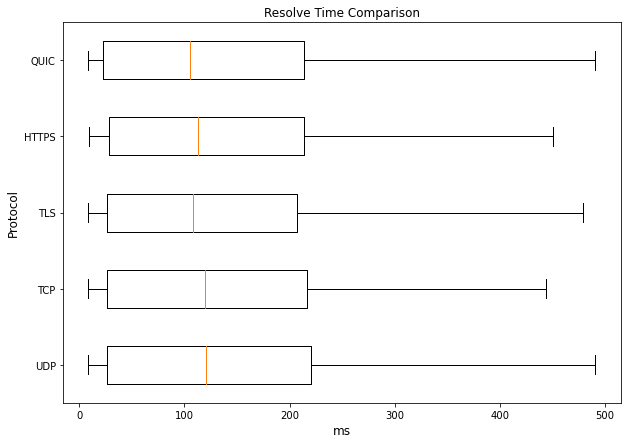

In [18]:
udpQueryTime = list(map(lambda x: x["query_time"] / 1000000, udp))
tcpQueryTime = list(map(lambda x: x["query_time"] / 1000000, tcp))
tlsQueryTime = list(map(lambda x: x["query_time"] / 1000000, tls))
httpsQueryTime = list(map(lambda x: x["query_time"] / 1000000, https))
quicQueryTime = list(map(lambda x: x["query_time"] / 1000000, quic))

fig = plt.figure(figsize = (10, 7))
ax = fig.add_subplot(111)
bp = ax.boxplot([udpQueryTime, tcpQueryTime, tlsQueryTime, httpsQueryTime, quicQueryTime], vert = 0, showfliers = False)

ax.set_yticklabels(["UDP", "TCP", "TLS", "HTTPS", "QUIC"])

ax.set_xlabel('ms', fontsize = 12)
ax.set_ylabel("Protocol", fontsize = 12)
plt.title("Resolve Time Comparison")

plt.show(bp)

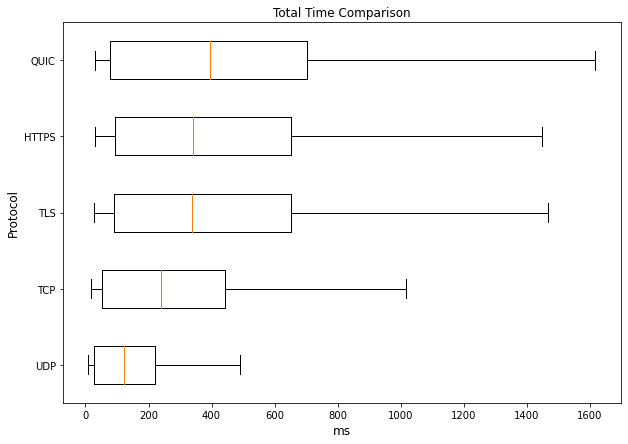

In [19]:
udpTotalTime = list(map(lambda x: x["total_time"] / 1000000, udp))
tcpTotalTime = list(map(lambda x: x["total_time"] / 1000000, tcp))
tlsTotalTime = list(map(lambda x: x["total_time"] / 1000000, tls))
httpsTotalTime = list(map(lambda x: x["total_time"] / 1000000, https))
quicTotalTime = list(map(lambda x: x["total_time"] / 1000000, quic))

fig = plt.figure(figsize = (10, 7))
ax = fig.add_subplot(111)
bp = ax.boxplot([udpTotalTime, tcpTotalTime, tlsTotalTime, httpsTotalTime, quicTotalTime], vert = 0, showfliers = False)

ax.set_yticklabels(["UDP", "TCP", "TLS", "HTTPS", "QUIC"])

ax.set_xlabel("ms", fontsize = 12)
ax.set_ylabel("Protocol", fontsize = 12)
plt.title("Total Time Comparison")

plt.show(bp)

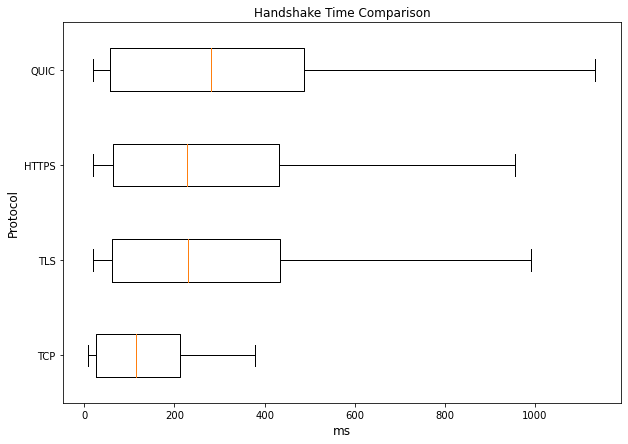

In [20]:
udpSetupTime = list(map(lambda x: x["udp_socket_setup_duration"] / 1000000, udp))
tcpSetupTime = list(map(lambda x: x["tcp_handshake_duration"] / 1000000, tcp))
tlsSetupTime = list(map(lambda x: (x["tcp_handshake_duration"] + x["tls_handshake_duration"]) / 1000000, tls))
httpsSetupTime = list(map(lambda x: (x["tcp_handshake_duration"] + x["tls_handshake_duration"]) / 1000000, https))
quicSetupTime = list(map(lambda x: x["q_ui_c_handshake_duration"] / 1000000, quic))

fig = plt.figure(figsize = (10, 7))
ax = fig.add_subplot(111)
bp = ax.boxplot([tcpSetupTime, tlsSetupTime, httpsSetupTime, quicSetupTime], vert = 0, showfliers = False)

ax.set_yticklabels(["TCP", "TLS", "HTTPS", "QUIC"])

ax.set_xlabel("ms", fontsize = 12)
ax.set_ylabel("Protocol", fontsize = 12)
plt.title("Handshake Time Comparison")

plt.show(bp)

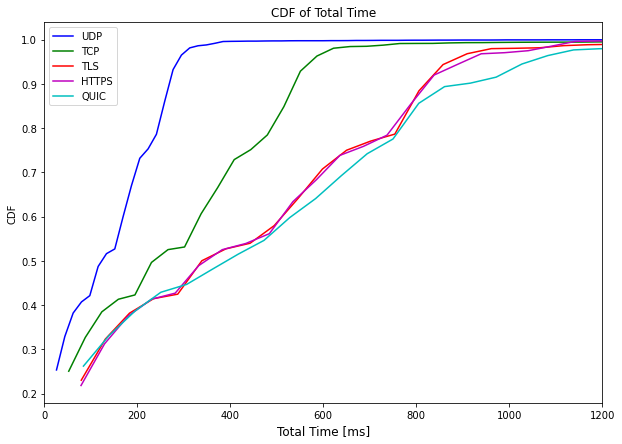

In [21]:
def calculateCDF(items):
    count, bins_count = np.histogram(items, bins="auto")

    pdf = count / sum(count)

    # using numpy np.cumsum to calculate the CDF
    # We can also find using the PDF values by looping and adding
    cdf = np.cumsum(pdf)
    return bins_count[1:], cdf

fig = plt.figure(figsize = (10, 7))
plt.plot(calculateCDF(udpTotalTime)[0], calculateCDF(udpTotalTime)[1], label="UDP", color = Colors.udp)
plt.plot(calculateCDF(tcpTotalTime)[0], calculateCDF(tcpTotalTime)[1], label="TCP", color = Colors.tcp)
plt.plot(calculateCDF(tlsTotalTime)[0], calculateCDF(tlsTotalTime)[1], label="TLS", color = Colors.tls)
plt.plot(calculateCDF(httpsTotalTime)[0], calculateCDF(httpsTotalTime)[1], label="HTTPS", color = Colors.https)
plt.plot(calculateCDF(quicTotalTime)[0], calculateCDF(quicTotalTime)[1], label="QUIC", color = Colors.quic)
plt.xlim([0, 1200])

plt.title("CDF of Total Time")
plt.xlabel("Total Time [ms]", fontsize = 12)
plt.ylabel("CDF")

plt.legend()

plt.show()

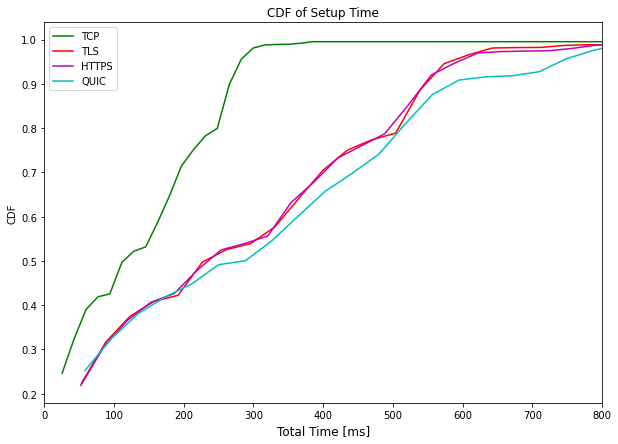

In [22]:
fig = plt.figure(figsize = (10, 7))
# plt.plot(calculateCDF(udpSetupTime)[0], calculateCDF(udpSetupTime)[1], label="UDP")
plt.plot(calculateCDF(tcpSetupTime)[0], calculateCDF(tcpSetupTime)[1], label="TCP", color = Colors.tcp)
plt.plot(calculateCDF(tlsSetupTime)[0], calculateCDF(tlsSetupTime)[1], label="TLS", color = Colors.tls)
plt.plot(calculateCDF(httpsSetupTime)[0], calculateCDF(httpsSetupTime)[1], label="HTTPS", color = Colors.https)
plt.plot(calculateCDF(quicSetupTime)[0], calculateCDF(quicSetupTime)[1], label="QUIC", color = Colors.quic)
plt.xlim([0, 800])

plt.title("CDF of Setup Time")
plt.xlabel("Total Time [ms]", fontsize = 12)
plt.ylabel("CDF")

plt.legend()

plt.show()

### Traceroutes per Protocol

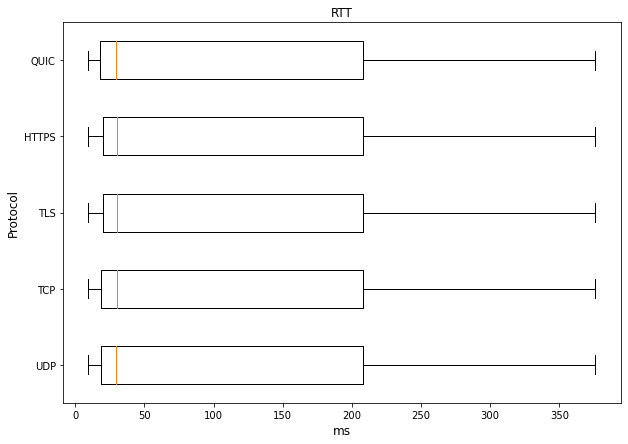

In [13]:
getMeanTraceroutes()

### QUIC Handshake Duration / RTT

In [37]:
times = getQUICMedianTraceroutes()
times["handshake/rtt"] = times.apply(lambda row: row["quic_handshake_duration"]/row["rtt"], axis = 1)
times["resolve-rtt"] = times.apply(lambda row: (row["query_time"] - row["rtt"]) / 1000000, axis = 1)

In [15]:
times_uncached = getQUICMedianTraceroutes(cacheWarming = True)
times_uncached["resolve-rtt"] = times_uncached.apply(lambda row: (row["query_time"] - row["rtt"]) / 1000000, axis = 1)

<AxesSubplot:xlabel='handshake/rtt'>

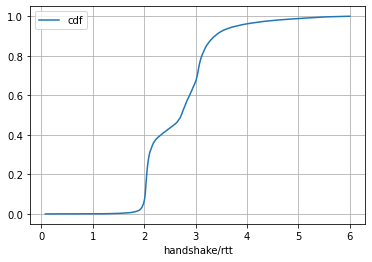

In [16]:
handshake = times[times["handshake/rtt"] <= 6]
handshake['cdf'] = handshake["handshake/rtt"].rank(method = 'average', pct = True)
handshake.sort_values("handshake/rtt").plot(x = 'handshake/rtt', y = 'cdf', grid = True)

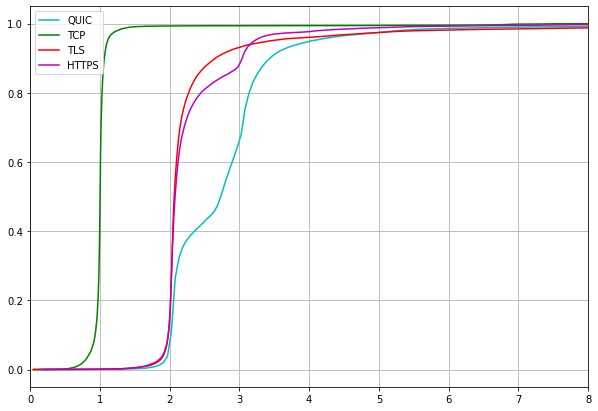

In [56]:
def plotHandshake():
    def filterNA(df):
        return df[df["handshake/rtt"].notna()]["handshake/rtt"].tolist()
    
    def addTLS(row):
        if row["tcp_handshake_duration"] and row["tls_handshake_duration"]:
            return (row["tcp_handshake_duration"] + row["tls_handshake_duration"])/row["rtt"]
        return np.nan
    
    quicTimes = getQUICMedianTraceroutes(protocol = "quic")
    tcpTimes = getQUICMedianTraceroutes(protocol = "tcp")
    tlsTimes = getQUICMedianTraceroutes(protocol = "tls")
    httpsTimes = getQUICMedianTraceroutes(protocol = "https")
    quicTimes["handshake/rtt"] = quicTimes.apply(lambda row: row["quic_handshake_duration"]/row["rtt"], axis = 1)
    tcpTimes["handshake/rtt"] = tcpTimes.apply(lambda row: row["tcp_handshake_duration"]/row["rtt"], axis = 1)
    tlsTimes["handshake/rtt"] = tlsTimes.apply(addTLS, axis = 1)
    httpsTimes["handshake/rtt"] = httpsTimes.apply(addTLS, axis = 1)
    
    fig = plt.figure(figsize = (10, 7))
    
    distQUIC = filterNA(quicTimes)
    distTCP = filterNA(tcpTimes)
    distTLS = filterNA(tlsTimes)
    distHTTPS = filterNA(httpsTimes)
    
    plt.plot(calculateCDF(distQUIC)[0], calculateCDF(distQUIC)[1], label="QUIC", color = Colors.quic)
    plt.plot(calculateCDF(distTCP)[0], calculateCDF(distTCP)[1], label="TCP", color = Colors.tcp)
    plt.plot(calculateCDF(distTLS)[0], calculateCDF(distTLS)[1], label="TLS", color = Colors.tls)
    plt.plot(calculateCDF(distHTTPS)[0], calculateCDF(distHTTPS)[1], label="HTTPS", color = Colors.https)
    
    plt.xlim([0, 8])
    plt.grid()
    plt.legend()
    
    plt.show()
    

plotHandshake()

### Resolve Time - RTT (Zoomed Out)

<AxesSubplot:xlabel='resolve-rtt'>

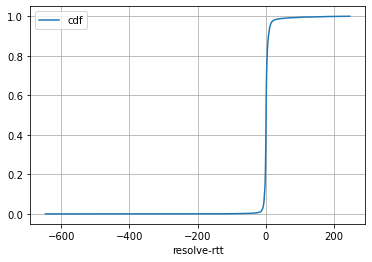

In [48]:
resolve_big = times[times["resolve-rtt"] < 250]
resolve_big['cdf'] = resolve_big["resolve-rtt"].rank(method = 'average', pct = True)
resolve_big.sort_values("resolve-rtt").plot(x = 'resolve-rtt', y = 'cdf', grid = True)

### Resolve Time - RTT (Zoomed In)

##### Cached

<AxesSubplot:xlabel='resolve-rtt'>

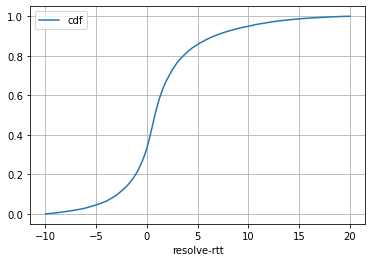

In [56]:
resolve_small = times[(times["resolve-rtt"] < 20) & (times["resolve-rtt"] > -10)]
resolve_small['cdf'] = resolve_small["resolve-rtt"].rank(method = 'average', pct = True)
resolve_small.sort_values("resolve-rtt").plot(x = 'resolve-rtt', y = 'cdf', grid = True)

##### Uncached

<AxesSubplot:xlabel='resolve-rtt'>

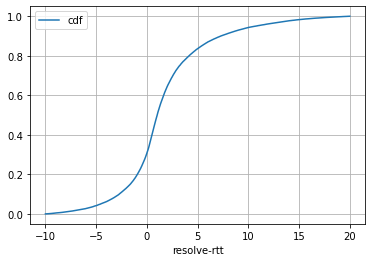

In [57]:
resolve_small_uncached = times_uncached[(times_uncached["resolve-rtt"] < 20) & (times_uncached["resolve-rtt"] > -10)]
resolve_small_uncached['cdf'] = resolve_small_uncached["resolve-rtt"].rank(method = 'average', pct = True)
resolve_small_uncached.sort_values("resolve-rtt").plot(x = 'resolve-rtt', y = 'cdf', grid = True)